# グラフの文字で英語以外を使えるようにする

In [1]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8b5a78c720ddbeed352c1112508fc47d647f439374ac86c80bc8d11b8efe0754
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


# 関数 save_fig：図の保存

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import japanize_matplotlib

def save_fig(plt, file_prefix, bbox_inches='tight'):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches=bbox_inches, pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches=bbox_inches, pad_inches = 0.2)

# 実習4.1：自由落下データの読み込み

In [3]:
import pandas as pd

df = pd.read_csv('dm4-1.csv',      # ファイル名
                 encoding='utf-8') # 文字コード

# 中身を表示
df

,時刻,位置
0,0,0.0
1,1,7.9
2,2,25.6
3,3,53.1
4,4,90.4
5,5,137.5
6,6,194.4
7,7,261.1
8,8,337.6
9,9,423.9


# 実習4.2：多項式回帰による初速と重力加速度の推定

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# データフレームから時刻の列を取り出す。
# scikit-learnの計算用に11行1列の形状に変形
t = df['時刻'].to_numpy().reshape(-1, 1)


# データフレームから位置の列を取り出す。
y = df['位置'].to_numpy()

#  多項式回帰モデル用に説明変数の値を計算するクラスのインスタンスを生成
# degree=2: 次数を2とする
# include_bias=False: 切片は考慮しない
pf = PolynomialFeatures(degree=2, include_bias=False)
x = pf.fit_transform(t) # tとtの2乗の値を計算

print('説明変数の形状:', x.shape)
print('説明変数')
print(x)

model=LinearRegression() # 線形回帰分析クラスのインスタンスを生成
model.fit(x, y)


w0=model.intercept_
print('w0:', w0)

w=model.coef_
v0 = w[0]
g = 2*w[1]
print('初速:', v0)
print('重力加速度:', g)

説明変数の形状: (11, 2)
説明変数
[[  0.   0.]
 [  1.   1.]
 [  2.   4.]
 [  3.   9.]
 [  4.  16.]
 [  5.  25.]
 [  6.  36.]
 [  7.  49.]
 [  8.  64.]
 [  9.  81.]
 [ 10. 100.]]
w0: 5.684341886080802e-14
初速: 2.9999999999999893
重力加速度: 9.8


# 実習4.3：測定データと回帰曲線の描画

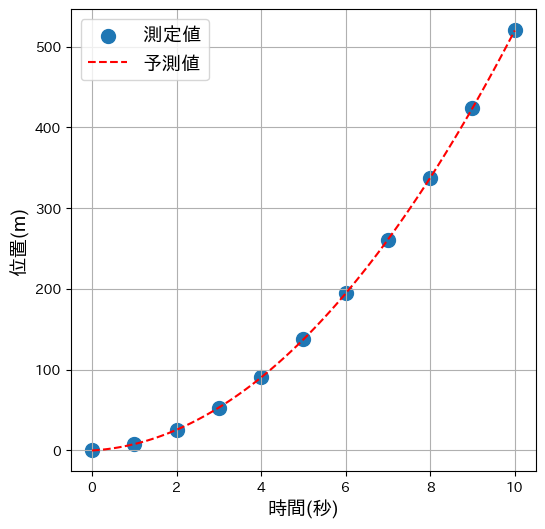

In [5]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import PolynomialFeatures

# 回帰曲線用の説明変数の値を生成する。
# 0以上、10以下の範囲で等間隔に100点を生成
u = np.linspace(0, 10, 100)
# scikit-learnの計算用に100行1列の形状に変形
u = u.reshape(-1, 1)

#  多項式回帰モデル用に説明変数の値を計算するクラスのインスタンスを生成
# degree=2: 次数を2とする
# include_bias=False: 切片は考慮しない
pf = PolynomialFeatures(degree=2, include_bias=False)
u2 = pf.fit_transform(u) # uとuの2乗の値を計算

# 学習したモデルパラメータを使い、説明変数u2に対する予測値を計算
y_pred=model.predict(u2)

plt.figure(figsize=(6, 6))
# 測定データのプロット
plt.scatter(t, y, s=100, label="測定値")
# 回帰直線の描画
plt.plot(u, y_pred, linestyle='dashed', label='予測値', color='red')
plt.xlabel('時間(秒)', fontsize=14)
plt.ylabel('位置(m)', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

# 実習4.4：トランジスタ数推移データの読み込み

In [14]:
import pandas as pd

df = pd.read_csv('dm4-2.csv',      # ファイル名
                 encoding='utf-8') # 文字コード

# 中身を表示
df

,年,トランジスタ数
0,1971.875000,2.308242e+03
1,1972.307692,3.554522e+03
2,1974.326923,6.097562e+03
3,1979.567308,2.916378e+04
4,1982.307692,1.357727e+05
...,...,...
94,2020.100000,3.040000e+10
95,2020.900000,1.600000e+10
96,2021.800000,5.700000e+10
97,2021.900000,5.820000e+10


# 実習4.5：トランジスタ数推移データの非線形回帰分析

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import leastsq

def moore(w, x):
    """
    予測値を計算する。
    w: パラメータ
    x: 説明変数の値
    """
    y = y0 * w[0]**(x * w[1])
    return y

def error_moore(w, x, y):
    """
    目的変数の値に対する予測値の誤差を計算する。
    w: パラメータ
    x: 説明変数の値
    y: 目的変数の値
    """
    return y - moore(w, x)

x = df.loc[:, '年'] # 説明変数の値を取り出す
y = df.loc[:, 'トランジスタ数'] # 目的変数の値を取り出す

x2 = x.to_numpy().copy() # Numpy配列へ変換。元の値が変わるのを防ぐためコピーを作成
x2 -= x2[0] # 先頭の値が0となるようにオフセット除去

y2 = y.to_numpy().copy() # Numpy配列へ変換。元の値が変わるのを防ぐためコピーを作成
y0 = y2[0] # 先頭の値（トランジスタ数）を定数として取り出す

w_init = np.ones(2) # 2つのパラメータの初期値を1とする
print('パラメータの初期値:', w_init)

# パラメータ推定
res = leastsq(error_moore,  # 目的変数の値に対する予測値の誤差を計算する関数
              w_init,       # パラメータの初期値
              args=(x2, y2)) # 説明変数と目的変数
w =res[0] # 推定したパラメータの値を取り出す
print('w0 = ', w[0])
print('w1 = ', w[1])

print('1年でのトランジスタ増加率 = ', w[0]**(w[1]))
print('2年でのトランジスタ増加率 = ', w[0]**(2*w[1]))

# 推定したパラメータを使い、予測値を計算
y_pred = moore(w, x2)

mse = mean_squared_error(y2, y_pred)
print('平均二乗誤差 = ', mse)

パラメータの初期値: [1. 1.]
w0 =  1.209117239736116
w1 =  1.7839998465399962
1年でのトランジスタ増加率 =  1.403213120745486
2年でのトランジスタ増加率 =  1.9690070622322862
平均二乗誤差 =  1.0882828414632841e+19


# 実習4.6：非線形回帰分析の結果の可視化

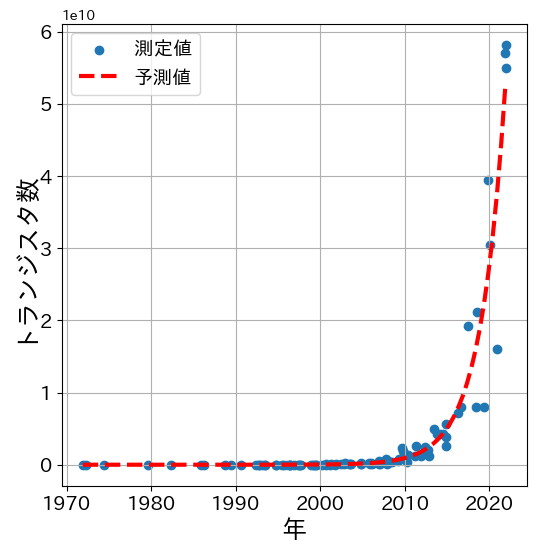

In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 回帰曲線用の説明変数の値を生成する。
# 説明変数の最小値以上、最大値以下の範囲で等間隔に100点を生成
x3 = np.linspace(x2.min(), x2.max(), 100)

# 予測値を計算
y_pred=moore(w, x3)

plt.figure(figsize=(6, 6))
# 測定値のプロット
plt.scatter(x, y2, marker='o', linestyle='None', label="測定値")
# 回帰直線の描画。x3 + x.min():西暦に戻す
plt.plot(x3 + x.min(), y_pred, linestyle='dashed', color='red', lw=3, label='予測値')
plt.xlabel('年', fontsize=18)
plt.ylabel('トランジスタ数', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

# 実習4.7：対数スケールでの単回帰分析

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x = df.loc[:, '年']
y = df.loc[:, 'トランジスタ数']

x2 = x.to_numpy().copy() # 元の値が変わるのを防ぐためコピーを作成
x2 -= x2.min()
x2 = x2.reshape((-1, 1)) # scikit-learnの計算用に98行1列の形状に変形

y2 = y.to_numpy().copy() # 元の値が変わるのを防ぐためコピーを作成
y2 = np.log10(y2) # 目的変数の値の常用対数をとる

model2=LinearRegression() # 単回帰分析用インスタンスを生成
model2.fit(x2, y2) # パラメータ推定

w0=model2.intercept_ # 切片
w1=model2.coef_[0]   # 傾き

print('w0 = ', w0)
print('w1 = ', w1)

print('1年でのトランジスタ増加率 = ', 10**w1)
print('2年でのトランジスタ増加率 = ', 10**(w1*2))

y_pred = model2.predict(x2) # 予測値の計算

mse = mean_squared_error(y2, y_pred)
print('平均二乗誤差（対数スケール） = ', mse)

mse = mean_squared_error(10**y2, 10**y_pred)
print('平均二乗誤差 = ', mse)

w0 =  3.134521230088265
w1 =  0.1508931760344801
1年でのトランジスタ増加率 =  1.4154455781877169
2年でのトランジスタ増加率 =  2.00348618481116
平均二乗誤差（対数スケール） =  0.05437568301440844
平均二乗誤差 =  1.191206200408764e+19


# 実習4.8：対数スケールでの単回帰分析の結果を可視化

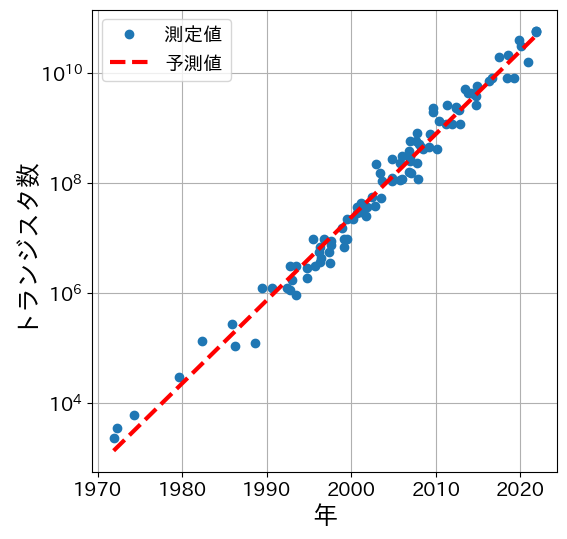

In [26]:
import matplotlib.pyplot as plt
import japanize_matplotlib

x3 = np.linspace(x2.min(), x2.max(), 100)
x3 = x3.reshape((-1, 1)) # scikit-learnの計算用に100行1列の形状に変形
y_pred=model2.predict(x3)

plt.figure(figsize=(6, 6))
# 10**y2: 目的変数の値を線形スケールに戻す
plt.plot(x, 10**y2, marker='o', linestyle='None', label="測定値")

# 10**y_pred: 予測値を線形スケールに戻す
plt.plot(x3 + x.min(), 10**y_pred, linestyle='dashed', color='red', lw=3, label='予測値')
# Y軸を常用対数スケールに設定。グラフにおけるY軸の値は常用対数で自動計算される。
plt.yscale('log')
plt.xlabel('年', fontsize=18)
plt.ylabel('トランジスタ数', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()